In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

Image ID: 163939
**************************************************
Categories: ['tv', 'dining table', 'cup', 'keyboard', 'spoon', 'book']
Super Categories: ['electronic', 'furniture', 'kitchen', 'indoor']
**************************************************
Q:what color are the noodles
A:white
Q:is the noodles in liquid
A:yes
Q:is the cup big
A:medium
Q:does the cup have a handle
A:yes
Q:is the computer on
A:i think so
Q:what color is the computer
A:i can only see the bottom of the screen and the keyboard, so silver
Q:is the computer a laptop
A:nope
Q:is there a person
A:nope
Q:is there a chair
A:can't see that much of the scene
Q:is there a desk
A:yes

**************************************************


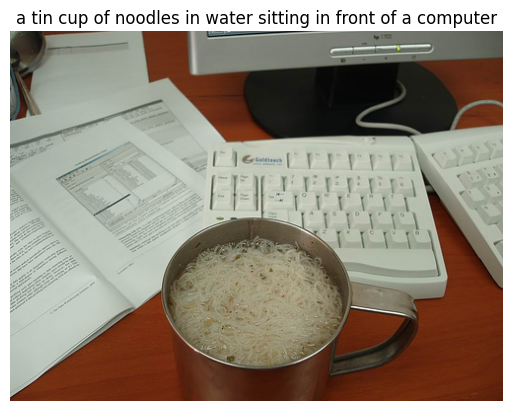

person similarity: 0.2169189453125
animal similarity: 0.226318359375
vehicle similarity: 0.2169189453125
outdoor similarity: 0.2054443359375
accessory similarity: 0.239013671875
sports similarity: 0.2274169921875
kitchen similarity: 0.251953125
food similarity: 0.253173828125
furniture similarity: 0.21630859375
electronic similarity: 0.229248046875
appliance similarity: 0.234375
indoor similarity: 0.197021484375


In [2]:
data_loader = loaders.DataLoader(data_source = "qa")
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

In [ ]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]

df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()




In [ ]:
clip_image = calculate_image_features(df_table)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))

encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)

df_table = pd.concat([df_table, encoded_df], axis=1)

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

def calculate_image_score(row):
    image_path = f"{dataset_dir}/qaood/sample/COCO_train2014_{row['image_id']:0>12}.jpg"
    image = Image.open(image_path)
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(preprocessed_image)


    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text = 'Category ' + categories
        text_tokens = clip.tokenize([text]).to(device)  
        with torch.no_grad():
            text_features = model.encode_text(text_tokens)
        cosine_sim_current = F.cosine_similarity(image_features, text_features).item()
        cosine_sim += np.exp(cosine_sim_current*10)
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)

    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_image_score, axis=1))

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score_max']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.8)

In [ ]:
fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.8)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiLabelNN(nn.Module):
    def __init__(self, input_size=512, output_size=11):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256) 
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, 64) 
        self.fc4 = nn.Linear(64, output_size)    
        self.relu = nn.ReLU()           
        self.sigmoid = nn.Sigmoid()    

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  
        return x



In [ ]:
df_ind = df_table[df_table['OOD'] == 0]
df_ind_train = df_ind.sample(frac=0.8, random_state=0)
df_ind_train = df_ind_train.loc[np.sort(df_ind_train.index)]
df_test = df_table.drop(df_ind_train.index)

In [ ]:
X_train = clip_image.loc[df_ind_train.index]
X_test = clip_image.loc[df_test.index]

In [ ]:
def evaluate(model, data_loader, loss_function):
    model.eval()  
    total_loss = 0
    total_accuracy = 0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            predictions = outputs > 0.5 
            total_accuracy += (predictions == labels.byte()).all(dim=1).float().mean().item()
            total_samples += 1

    average_loss = total_loss / total_samples
    average_accuracy = total_accuracy / total_samples

    return average_loss, average_accuracy

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 32
EPOCH = 20

X_train_tensor = torch.tensor(X_train.values).float() 
Y_train_tensor = torch.tensor(np.vstack(df_ind_train['encoded_label'].values)).float()

X_test_tensor = torch.tensor(X_test.values).float()
Y_test_tensor = torch.tensor(np.vstack(df_test['encoded_label'].values)).float()

dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

model = MultiLabelNN()
loss_function = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

for epoch in range(EPOCH):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

    average_loss, average_accuracy = evaluate(model, train_loader, loss_function)
    test_loss, test_accuracy = evaluate(model, test_loader, loss_function)

    print(f'Epoch {epoch+1}, Train Loss: {average_loss:.4f}, Train Accuracy: {average_accuracy:.4f}')
    print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [ ]:
model.eval()  

with torch.no_grad():  
    for inputs, labels in test_loader:
        outputs = model(inputs)


In [ ]:
outputs = outputs.numpy()

In [ ]:
outputs_energy = -np.log(1+outputs/(1-outputs))

In [ ]:
outputs_energy_sum = outputs_energy.sum(axis=1)

In [ ]:
outputs_energy_sum

In [ ]:
df_test['energy'] = outputs_energy_sum

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
fpr_evaluation(df_test['OOD'].values, df_test['energy'].values, 0.95)